# Is the cinema sexist? 

**Authors**
- Marjorie Cayatte
- Maxime Leriche
- Madeleine Robert
- Arthur Tabary

**Date**\
November, 18th, 2022

In this Notebook, we present our initial analyses and results. We first import the necessay libraries. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
import json
from datetime import datetime, date, time
import requests

## 1 - Get the different datasets

We import the following datasets from the **CMU Movie Summary Corpus** as DataFrame: 
- *movie.metadata.tsv.gz*: metadata for 81,741 movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase. 
- *character.metadata.tsv.gz*: metadata for 450,669 characters aligned to the movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase. 

In [2]:
# Import movie.metadata and format column names
movies = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
movies.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


- We will clean the DataFrame *movies* by splitting the columns with multiple data into multiple columns. For example, the column "movie_countries" contains the Freebase ID and the country. To do so, we tranform dictionnary in list which will be easier to manipulate. 

In [3]:
# Separate dictionaries into 2 columns with Freebase id and value
movies["movie_countries_id"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_countries"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.values()))
movies["movie_genres_id"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_genres"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.values()))
movies["movie_languages_id"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_languages"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.values()))
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv]


In [4]:
# Load character metadata and format column names
characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
characters.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
characters.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## 2 - What genre are included in the dataset ?

In this part, we analyze the feature "movie_genres" to understand how we can include it as a parameter to answer our main question. 

### 2.1 - Transform and clean the dataset

- We notice some corrupted values and correct them. 

In [5]:
# Warning, some rows of the dataset have wrong release dates: here 1010 instead of 2010
movies.iloc[62836]

wiki_movie_ID                                             29666067
freebase_movie_ID                                       /m/0fphzrf
movie_name                                          Hunting Season
movie_release_date                                      1010-12-02
movie_box_off_rev                                       12160978.0
movie_runtime                                                140.0
movie_languages               [Turkish Language, English Language]
movie_countries                                           [Turkey]
movie_genres             [Crime Fiction, Mystery, Drama, Thriller]
movie_countries_id                                     [/m/01znc_]
movie_genres_id       [/m/0lsxr, /m/02n4kr, /m/07s9rl0, /m/01jfsb]
movie_languages_id                        [/m/02hwyss, /m/02h40lc]
Name: 62836, dtype: object

In [6]:
# Replace the wrong value of 1010
movies.loc[62836, 'movie_release_date'] = '2010-12-02'

In [7]:
# Keep only the year of the release date
movies['movie_release_date'] = movies['movie_release_date'].str[:4]

## 3 - Geographic distribution of movies

### 3.1 - Gather region for each country

- For this part, we use an online API which provides varied data about each country, and will use the name given in the dataset to gather the corresponding region.

- Since both datasets come from different sources, it is likely that the country names won't match, so we might need to do some changes. 

In [8]:
# Get region for each country

region_lst = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
countries = {"country" : [],
"region" : []}

country_lst = [[], []]
df_countries = pd.DataFrame(columns = ["country", "region"])

for region in region_lst:
    response = requests.get("https://restcountries.com/v3.1/region/" + region).json()

    for elem in response:
        countries["country"].append(elem.get("name").get("common"))
        countries["region"].append(region)

df_countries = pd.DataFrame.from_dict(countries)
df_countries.head()

,country,region
0,Mauritania,Africa
1,Niger,Africa
2,Togo,Africa
3,Madagascar,Africa
4,Algeria,Africa


### 3.2 - Missing countries in our country-region table

We now want to answer the following questions: 
- What are the unreferenced countries?
- For each of these countries, how many movies did they produce/co-produce?
- Which country reprensent 95% of all thoses movies? 

We could then keep only these countries, and update the country-region reference table. 

There is a total of 8053 movies that contain a null movie name (NaN) among the producing countries (movie_countries column)
98.87% of them only contain 1 NaN occurence, up to 7962.


1    7962
2      83
3       7
5       1
dtype: int64

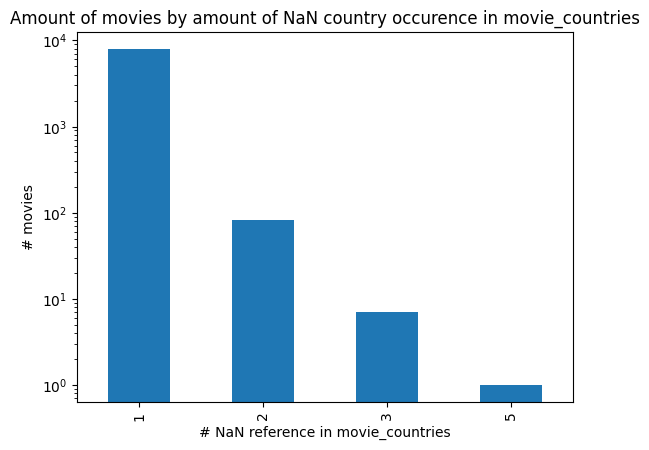

In [9]:
all_movie_countries = movies.explode("movie_countries", ignore_index = True)
unique_movie_countries = all_movie_countries.loc[all_movie_countries["movie_countries"].isnull()]
grunique_movie_countries = unique_movie_countries.groupby("movie_name").size()
grunique_movie_countries = grunique_movie_countries.groupby(grunique_movie_countries).size()
ax = grunique_movie_countries.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("# NaN reference in movie_countries") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies by amount of NaN country occurence in movie_countries");
print(f"There is a total of {grunique_movie_countries.sum()} movies that contain a null movie name (NaN) among the producing countries (movie_countries column)")
print(f"{grunique_movie_countries.iloc[0]/grunique_movie_countries.sum() :.2%} of them only contain 1 NaN occurence, up to {grunique_movie_countries.max()}.")
grunique_movie_countries

95% of these movies come from ['United States of America' 'West Germany']


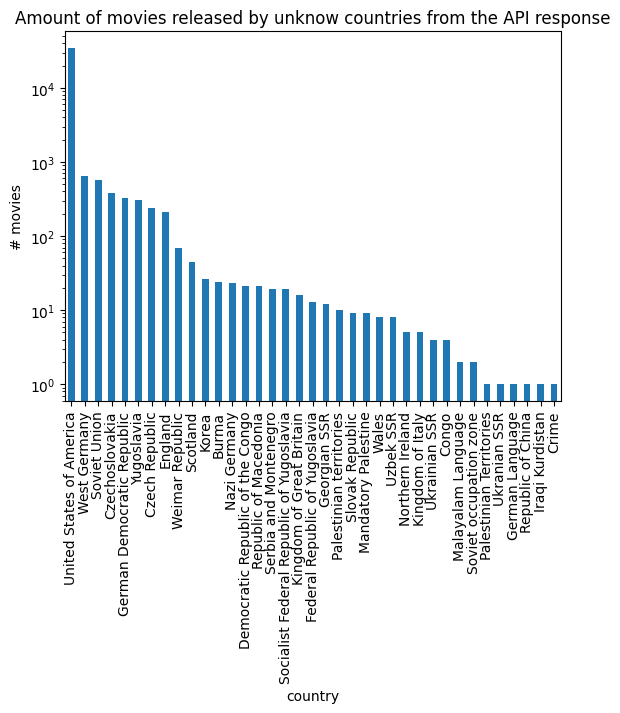

In [10]:
######################################
# What are the unreferenced countries?
######################################

# Get all unique countries in our dataset
all_movie_countries = movies["movie_countries"].explode(ignore_index = True)
unique_movie_countries = all_movie_countries.unique()

# Referenced unique countries
referenced_countries = df_countries["country"].unique()

# Unreferenced countries in the dataset
unreferenced = [a for a in unique_movie_countries if a not in referenced_countries]

###########################################################################
# For each of these countries, how many movies did they produce/co-produce?
###########################################################################

df_unreferenced = all_movie_countries.groupby(all_movie_countries).size()
df_unreferenced = df_unreferenced[df_unreferenced.index.isin(unreferenced)].sort_values(ascending = False)

# Plot
ax = df_unreferenced.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("country") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies released by unknow countries from the API response");

# Get country names representing 95% of movie quantity
percentile_95 = df_unreferenced.sum() * 0.95
countries_to_keep = df_unreferenced[df_unreferenced.cumsum() <= percentile_95]

print(f"95% of these movies come from {countries_to_keep.index.values}")

# Add these countries to the API dataframe response
countries_to_add = dict(zip(["country", "region"], [countries_to_keep.index.values.tolist(), ["Americas", "Europe"]]))
countries_to_add = pd.DataFrame.from_dict(countries_to_add)
df_countries = pd.concat([df_countries, countries_to_add], ignore_index=True)


# Update the list of unreferenced countries
for country in countries_to_keep.index.values.tolist():
    unreferenced.pop(unreferenced.index(country))

### 3.3 - Clean dataset

- We now remove all movies with a "movie_country" item in one of the unreferenced country we do not want to consider.

In [11]:
movie_count = len(movies)
movies = movies[movies.movie_countries.apply(lambda x: not any(i in unreferenced for i in x))]
print(f"{movie_count - len(movies)} movies were removed.")

2282 movies were removed.


### 3.4 - Add the region information to our dataset

- The *region* column contains the continent in which the movie was produced (can be different regions if multiple countries from different continent co-produced the movie).

In [12]:
# Add region column
# For each country in movies.movie_countries, get the region (remove region duplicates)
def get_region(country_lst):
    output = []
    for country in country_lst:
        try:
            output.append(df_countries.loc[df_countries["country"] == country]["region"].values[0])
        except:
            raise KeyError(f"{country} not found in the reference list")

    #remove duplicates
    return list(set(output))

movies_copy = movies.copy()
movies_copy["region"] = movies_copy.loc[:, ("movie_countries")].apply(lambda x: get_region(x))
movies = movies_copy.copy()
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,region
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[Americas]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],[Americas]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],[Europe]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],[Europe]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],[Europe]


### 4.1 - Evaluating and filtering out missing values

In [13]:
# Create a DataFrame keeping only characters where actors have reported gender
characters_gender = characters[characters["actor_gender"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains {} rows.'.format(len(characters_gender) / len(characters), len(characters_gender)))

 89.9% of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains 405060 rows.


In [14]:
# What are the possible different values for characters_gender? 
pd.Categorical(characters_gender.actor_gender)

['F', 'F', 'M', 'M', 'F', ..., 'F', 'M', 'F', 'M', 'M']
Length: 405060
Categories (2, object): ['F', 'M']

### 4.2 - What is the repartition between male and female characters? 

66.72% of reported characters are played by male actors.


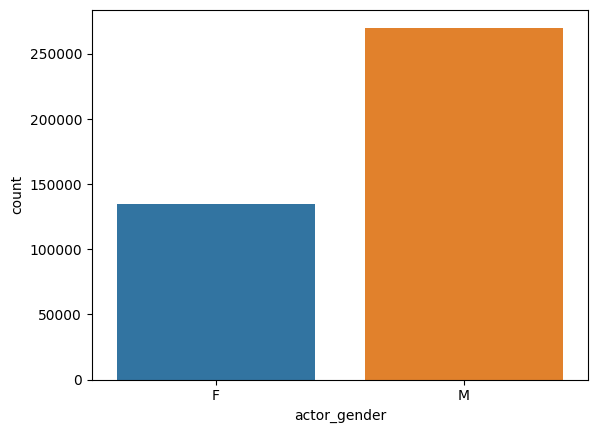

In [15]:
# Create two DataFrame for characters played by female/male
characters_female = characters_gender[characters_gender['actor_gender']== 'F']
characters_male = characters_gender[characters_gender['actor_gender']== 'M']

# Plot the repartition
sns.countplot(x = characters_gender['actor_gender'])
print("{:.2%} of reported characters are played by male actors.".format(len(characters_male)/len(characters_gender)))

### 4.3 - How is age of male characters compared to age of female characters? 

- We want to compare age of the actors and actresses palying roles reported in *character*. 

In [16]:
# Clear out characters_gender where age is not reported (characters_gender_age)
characters_gender_age = characters_gender[characters_gender["actor_age_movie"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains {} rows.'.format(len(characters_gender_age) / len(characters), len(characters_gender_age)))

 64.5% of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains 290770 rows.


- We first explore and clean the data. 

In [17]:
# Explore basic statistics
characters_gender_age.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,2.907700e+05,139639.000000,290770.000000
mean,1.302929e+07,1.789524,37.804148
std,1.080402e+07,4.380801,20.616015
min,3.300000e+02,0.610000,-7896.000000
25%,3.052538e+06,1.680000,28.000000
50%,1.014264e+07,1.750000,36.000000
75%,2.261175e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


- The negative values do not make sense: we filter them out.

In [18]:
# Keep only rows where "actor_age_movie" is positive
characters_gender_age = characters_gender_age[characters_gender_age['actor_age_movie'] >= 0]

### 4.4 - How about height? 

- We can perform the same analysis for height. 

In [19]:
# Clear out characters_gender where height is not reported (characters_gender_age)
characters_gender_height = characters_gender[characters_gender["actor_height"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains {} rows.'.format(len(characters_gender_height) / len(characters), len(characters_gender_height)))

 34.3% of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains 154663 rows.


In [20]:
# Explore basic statistics on height
characters_gender_height["actor_height"].describe()

count    154663.000000
mean          1.788966
std           4.382216
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max         510.000000
Name: actor_height, dtype: float64

- 510 cm seems to be a corrupted value. We filter rows where height is above 2,72m (biggest height reported).

In [21]:
# Keep only rows where "actor_height" is below 2.72m
characters_gender_height = characters_gender_height[characters_gender_height['actor_height'] < 2.73]

## 5 - Representation of women in movies

### 5.1 - Percentage of women in movies

- First, we want to compute the percentage of women in each movie where there is a reported character with a gender. 

In [22]:
# creation of a column with "True" for womens
characters_gender['female'] = characters_gender.actor_gender=='F'

# compute percentage of women by movie
percentage_female=  characters_gender.groupby(characters_gender['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()
percentage_female.head()

C:\Users\ma2le\AppData\Local\Temp\ipykernel_30488\1310754118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_gender['female'] = characters_gender.actor_gender=='F'
C:\Users\ma2le\AppData\Local\Temp\ipykernel_30488\1310754118.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  percentage_female=  characters_gender.groupby(characters_gender['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()


,female
freebase_movie_ID,
/m/011_mj,0.142857
/m/011_p6,0.400000
/m/011_zy,0.250000
/m/011wtv,0.333333
/m/011x_4,0.294118


We create a new DataFrame where we merge *movies* with *percentage_female* to add the percentage of female for each movie. 

In [23]:
movies_female = movies.merge(percentage_female, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
movies_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,region,female
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[Americas],0.352941
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],[Americas],0.266667
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],[Europe],0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],[Europe],0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],[Europe],0.333333


- How many movies did we lose by merging? 

In [24]:
print("We kept {:.2%} of the DataFrame movies by merging.".format(len(movies_female)/len(movies)))

We kept 78.42% of the DataFrame movies by merging.


### 5.2 - Temporal evolution of female percentage in movies

We now want to examine how female percentage in movies evolved over time. 

In [25]:
movies_female_gp_year=movies_female.groupby(movies_female['movie_release_date'])[['movie_release_date','female']].mean()
movies_female_gp_year.head()

C:\Users\ma2le\AppData\Local\Temp\ipykernel_30488\2222213228.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  movies_female_gp_year=movies_female.groupby(movies_female['movie_release_date'])[['movie_release_date','female']].mean()


,female
movie_release_date,
1888,0.50
1891,0.00
1893,0.00
1894,0.25
1895,0.00


- We want to plot the percentage of women over time.

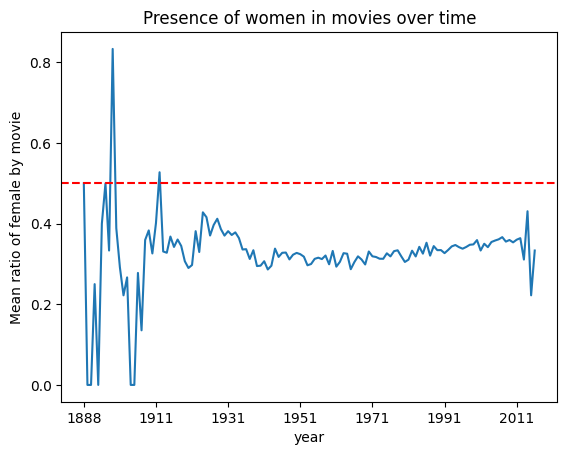

In [26]:
movies_female_gp_year.plot(legend=False)
plt.ylabel('Mean ratio of female by movie')
plt.xlabel('year')
plt.title('Presence of women in movies over time')
plt.axhline(y=0.5,color ='red', ls='--')

## 6 - How to evaluate the success of a movie ? 

In our dataset, the only feature we have to measure the success of a movie is the box office revenue. We will first analyze this feature on our dataset. 

### 6.1 - Cleaning and missing values

In [27]:
print("{:.2%} of the movies have a missing movie box office revenue value".format(movies.isnull().sum()['movie_box_off_rev']/len(movies)))

89.52% of the movies have a missing movie box office revenue value


- How are the missing values distributed over time ? 
- We calculate the number of movies per year which have a reported box office revenue. 

In [28]:
#Keep only movies with a value for box office revenue
movies_with_bor = movies[movies.movie_box_off_rev.isnull()==False]

#Group by year and count the number of movies
movies_with_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_release_date']].count()
movies_with_bor_gp_year.head()

,movie_release_date
movie_release_date,
1897,1
1914,4
1915,1
1920,1
1921,3


- To plot evolution of movies without missing values over time, we normalize on the total number of movies, as we saw in 2 that it strongly increased over time. 

In [29]:
#Compute number of movies with missing values over total number of movies per year
movie_count_all_gp_year = movies.groupby(movies['movie_release_date'])[['movie_release_date']].count()
movie_count_all_gp_year['ratio_bor']=movies_with_bor_gp_year['movie_release_date']/movie_count_all_gp_year['movie_release_date']

Text(0.5, 1.0, 'Ratio of values available per year for the feature "movie_box_off_rev"')

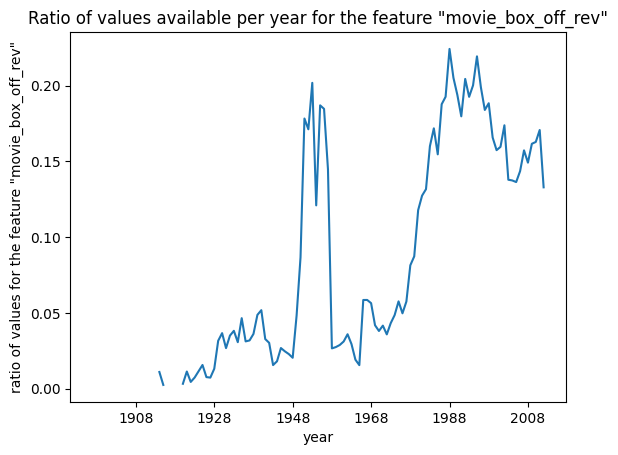

In [30]:
#Plot the distribution
movie_count_all_gp_year['ratio_bor'].plot(legend=False)
plt.ylabel('ratio of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Ratio of values available per year for the feature "movie_box_off_rev"')

We can see that the ratio of movies without missing values increases with time; however, the ratio never exceeds 20% of the dataset, which is quite low. 

### 6.2 - Evolution of average box office revenue over time

We now want to analyze the evolution of the box office revenue over time. 

In [31]:
#Compute the average box office revenue by year
movies_mean_bor_gp_year = movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean()
movies_mean_bor_gp_year.head()

,movie_box_off_rev
movie_release_date,
1897,1.000000e+05
1914,7.079320e+05
1915,5.000000e+07
1920,4.500000e+06
1921,2.633333e+06


Text(0.5, 1.0, 'Evolution of the average box office revenue')

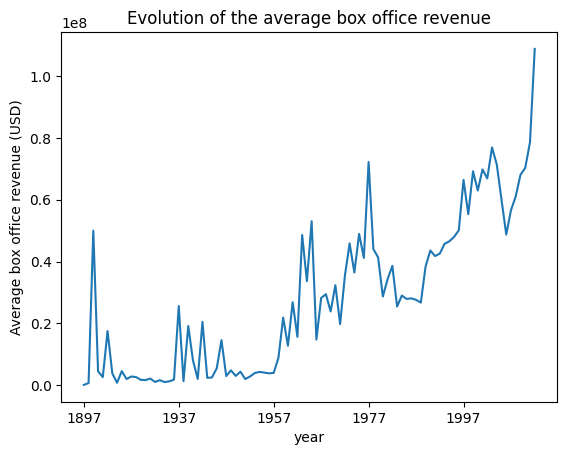

In [32]:
#Plot the distribution
movies_mean_bor_gp_year.plot(legend=False)
plt.ylabel('Average box office revenue (USD)')
plt.xlabel('year')
plt.title('Evolution of the average box office revenue')

* To be perfectly accurate in comparing box office receipt comparison over time, we should at least adjust revenues for dollar inflation. One could go further and consider even more adjustements to be even more precise as explained in [this article](https://wwwold.usi.edu/media/3655032/How-the-MPA-Miscalculates.pdf).

- Even if these results are interesting, the amount of missing values is quite problematic. To evaluate the success of a movie, we can also look at the ratings of the movies. The data is not available in our dataset but we can use IMDb.

### 6.4 - Rating of movies

In [33]:
imdb = pd.read_csv('Data/Imdb/processed_imdb_dataset.csv')
imdb.head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,0,/m/03vyhn,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55271
1,1,/m/0crgdbh,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,2,/m/01mrr1,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,590
3,3,/m/03cfc81,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,4,/m/02qc0j7,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2160


- We can start by computing the average rating by year

In [34]:
#Group rating by year and compute mean rating 
imdb_rating_gp_year = imdb.groupby(imdb['startYear'])[['averageRating']].mean()
imdb_rating_gp_year.head()

,averageRating
startYear,
1888,7.300000
1889,5.000000
1890,5.200000
1891,4.966667
1892,6.050000


Text(0.5, 1.0, 'Evolution of movie ratings')

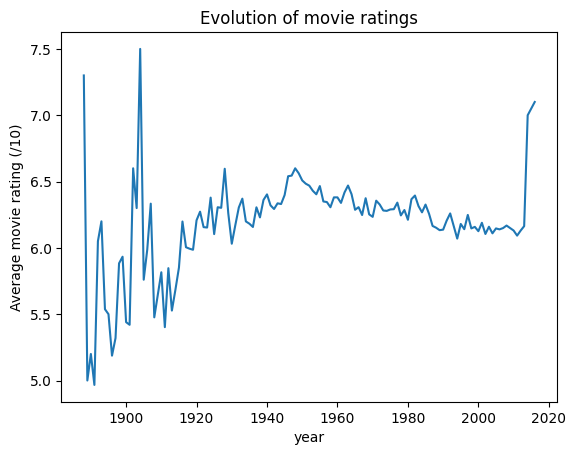

In [35]:
#Plot the distribution
imdb_rating_gp_year.plot(legend=False)
plt.ylabel('Average movie rating (/10)')
plt.xlabel('year')
plt.title('Evolution of movie ratings')

In [36]:
# Merge imdb et movie metadata
imdb.sort_values(by = 'startYear', ascending = False).head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
16661,17361,/m/0c03gcc,tt2267968,movie,Kung Fu Panda 3,Kung Fu Panda 3,2016,95,"Action,Adventure,Animation",7.1,159988
28886,30084,/m/0k3lpxc,tt5308316,tvEpisode,Saving Mr. Banks,Saving Mr. Banks,2014,6,"Documentary,Short",7.4,15
19214,20036,/m/0kdy118,tt1959490,movie,Noah,Noah,2014,138,"Action,Adventure,Drama",5.8,255917
39097,40658,/m/0fkf28,tt0816692,movie,Interstellar,Interstellar,2014,169,"Adventure,Drama,Sci-Fi",8.6,1806941
30260,31518,/m/0k0tq97,tt1587310,movie,Maleficent,Maleficent,2014,97,"Adventure,Family,Fantasy",6.9,376315


### 6.5 - Correlation between rating and box office revenue

- Now we have two measures of a movie's success and we wonder wether these two features are correlated. As we saw in the previous parts, there are many missing values on box office revenues. If these two features are strongly correlated, we could keep only rating as a measure of success and have a larger dataset to work on. 

In [37]:
#Merge movies with box office revenue and dataset with ratings on freebase_movie_ID
correl = movies_with_bor.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
correl.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55271
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2160
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",[/m/07ssc],...,7,tt0097499,movie,Henry V,Henry V,1989,137,"Biography,Drama,History",7.5,30177
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",[/m/09c7w0],...,8,tt0058331,movie,Mary Poppins,Mary Poppins,1964,139,"Comedy,Family,Fantasy",7.8,173341
4,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",[/m/09c7w0],...,14,tt0255819,movie,Baby Boy,Baby Boy,2001,130,"Crime,Drama,Romance",6.4,15014


In [38]:
#Compute Pearson correlation coefficient
stats.pearsonr(correl['movie_box_off_rev'],correl['numVotes'])

PearsonRResult(statistic=0.6436415293354109, pvalue=0.0)

- The Pearson linear coefficient is low but significantly positive ($ p < 0.05$). The correlation seems too low to keep only one feature as a measure of success. 

# P3

## Ratio of females by movie popularity

In [39]:
#Merge movies with female ratio and dataset with number of votes on freebase_movie_ID
popularity = movies_female.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
popularity.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55271
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],...,1,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],...,2,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,590
3,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",[/m/09c7w0],...,3,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2160


In [40]:
#Group dataset by number of votes and compute mean female ratio 
popularity_females = popularity.groupby(popularity['numVotes'])[['female']].mean()
popularity_females.head()

,female
numVotes,
5,0.404840
6,0.338428
7,0.359426
8,0.376135
9,0.336969


Text(0.5, 1.0, 'Female ratio and movie popularity')

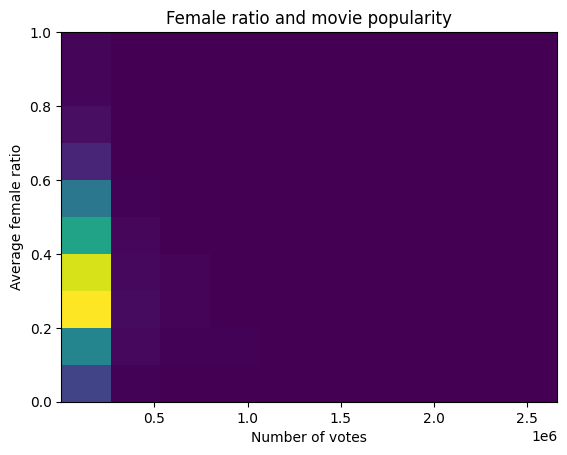

In [41]:
#Plot the distribution
# popularity_females.plot(kind='scatter',legend=False)
plt.hist2d(popularity_females.index,popularity_females['female'])#, '.', linewidth=0.01)
# sns.jointplot(x=popularity['numVotes'], y=popularity['female'], kind="hex")
# sns.heatmap(popularity_females)
plt.ylabel('Average female ratio')
plt.xlabel('Number of votes')

plt.title('Female ratio and movie popularity')

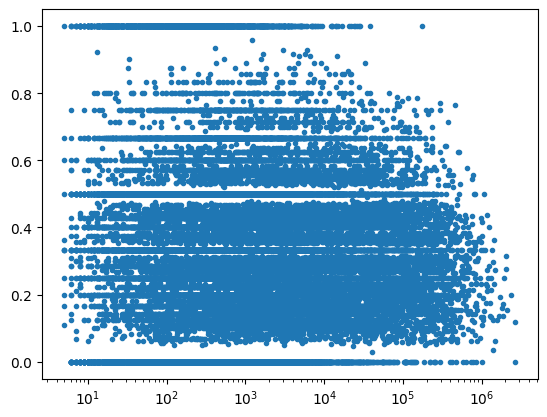

In [42]:
plt.plot(popularity['numVotes'],popularity['female'], '.', linewidth=0.01)
plt.xscale('log')

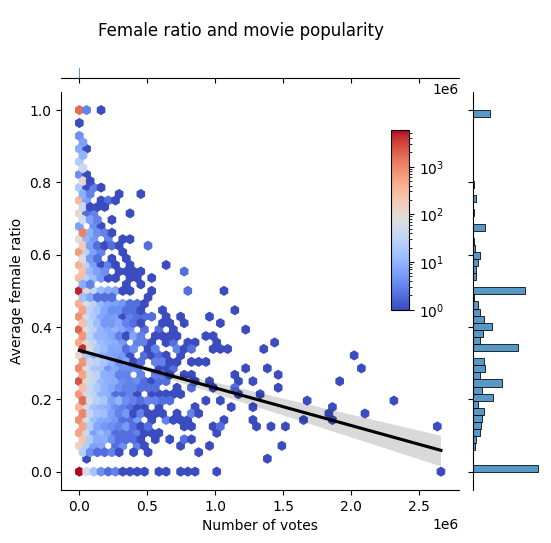

In [44]:
hexplot = sns.jointplot(x=popularity['numVotes'], y=popularity['female'], kind="hex", bins='log', cmap="coolwarm")
sns.regplot(x=popularity['numVotes'], y=popularity['female'], ax=hexplot.ax_joint, scatter=False, color='black')
plt.ylabel('Average female ratio')
plt.xlabel('Number of votes')
plt.subplots_adjust(left=0.2, right=1, top=1, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([.75, .5, .03, .3])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.suptitle('Female ratio and movie popularity')
plt.show()


Text(0.5, 1.0, 'Female ratio and movie popularity')

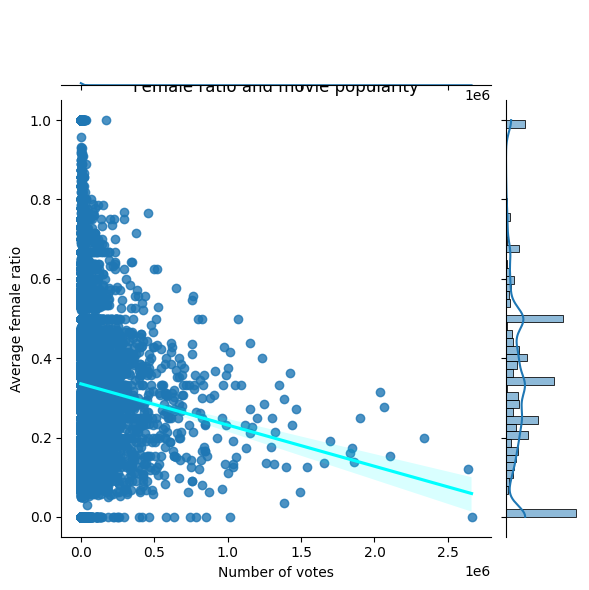

In [45]:
sns.jointplot(x=popularity['numVotes'], y=popularity['female'], kind="reg",joint_kws={'line_kws':{'color':'cyan'}})
plt.ylabel('Average female ratio')
plt.xlabel('Number of votes')

plt.title('Female ratio and movie popularity')

In [46]:
#Compute Pearson correlation coefficient
stats.spearmanr(popularity['numVotes'],popularity['female'])

SpearmanrResult(correlation=-0.002066047073216963, pvalue=0.6840513876906611)

## Ratio of females by ratings

Text(0.5, 1.0, 'Female ratio and movie ratings')

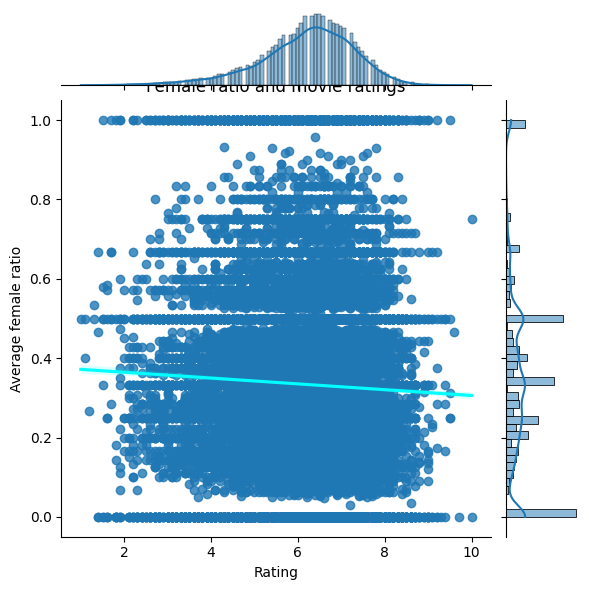

In [47]:
sns.jointplot(x=popularity['averageRating'], y=popularity['female'], kind="reg",joint_kws={'line_kws':{'color':'cyan'}})
plt.ylabel('Average female ratio')
plt.xlabel('Rating')

plt.title('Female ratio and movie ratings')

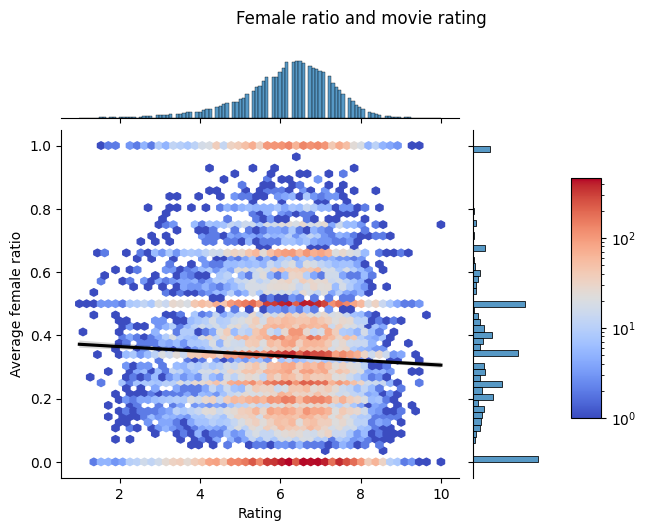

In [48]:
hexplot = sns.jointplot(x=popularity['averageRating'], y=popularity['female'], kind="hex", bins='log', cmap="coolwarm")
sns.regplot(x=popularity['averageRating'], y=popularity['female'], ax=hexplot.ax_joint, scatter=False, color='black')
plt.ylabel('Average female ratio')
plt.xlabel('Rating')
plt.subplots_adjust(left=0, right=0.8, top=0.9, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([.85, .3, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.suptitle('Female ratio and movie rating')
plt.show()


# Can women develop their career in cinema ?

To assess the development of career of an actor, we will look at the number of movie in which he payed.

In [60]:
characters.isnull().sum()

wiki_movie_ID                      0
freebase_movie_ID                  0
movie_release_date              9995
character_name                257875
actor_DOB                     106145
actor_gender                   45609
actor_height                  295845
actor_ethnicity               344611
actor_name                      1228
actor_age_movie               158113
freebase_char/actor_map_ID         0
freebase_char_ID              257865
freebase_actor_ID                815
dtype: int64

In [62]:
# we drop every character with no info about the gender of the actor
characters = characters.dropna(subset=['actor_gender'])

In [75]:
movie_by_character=characters.groupby(characters['freebase_actor_ID'])[['wiki_movie_ID']].count().add_suffix("_count")

In [76]:
movie_by_character.sort_values(by=['wiki_movie_ID_count'])

,wiki_movie_ID_count
freebase_actor_ID,
/m/0clr_r5,1
/m/0gm5psd,1
/m/0gm5pmp,1
/m/0gm5p6r,1
/m/0gm5krv,1
...,...
/m/02hkv5,225
/m/02fbpz,234
/m/0lh0c,299


In [77]:
movie_by_character.head(20)

,wiki_movie_ID_count
freebase_actor_ID,
/m/010p3,12
/m/010q36,1
/m/010wx,1
/m/010xjr,54
/m/0112yl,48
/m/011_0k,1
/m/011_24,2
/m/011_2h,1
/m/011_3s,34


(array([5.2839e+04, 1.3784e+04, 7.0300e+03, 4.4750e+03, 0.0000e+00,
        3.1430e+03, 2.2260e+03, 1.7490e+03, 1.4500e+03, 0.0000e+00,
        1.2090e+03, 9.7500e+02, 8.0400e+02, 6.9500e+02, 0.0000e+00,
        6.0700e+02, 5.3900e+02, 5.3000e+02, 3.9300e+02, 0.0000e+00,
        3.8200e+02, 3.1700e+02, 3.1700e+02, 0.0000e+00, 2.7900e+02,
        2.5700e+02, 2.1900e+02, 1.8400e+02, 0.0000e+00, 1.8300e+02,
        1.7000e+02, 1.7000e+02, 1.3000e+02, 0.0000e+00, 1.5100e+02,
        1.2000e+02, 1.2900e+02, 9.5000e+01, 0.0000e+00, 1.0800e+02,
        1.0000e+02, 8.3000e+01, 0.0000e+00, 9.1000e+01, 7.5000e+01,
        6.6000e+01, 6.0000e+01, 0.0000e+00, 7.4000e+01, 5.9000e+01,
        7.4000e+01, 6.4000e+01, 0.0000e+00, 4.9000e+01, 5.3000e+01,
        5.0000e+01, 3.8000e+01, 0.0000e+00, 3.0000e+01, 3.4000e+01,
        3.8000e+01, 0.0000e+00, 3.5000e+01, 2.6000e+01, 2.7000e+01,
        2.3000e+01, 0.0000e+00, 2.9000e+01, 3.4000e+01, 2.4000e+01,
        2.2000e+01, 0.0000e+00, 2.1000e+01, 2.20

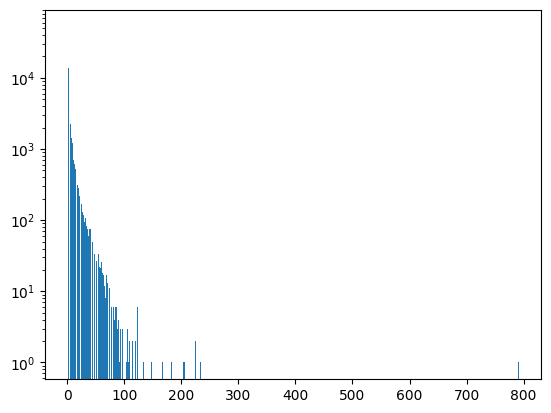

In [78]:
plt.hist(movie_by_character, bins = 1000, log=True)